In [1]:
library(rvest)
library(tidyverse)
library(dplyr)
library(patchwork)
library(tm)
library(tau)
source("R/R_limpeza_string.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Carregando pacotes exigidos: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate



Attaching package: ‘tau’


The following object is masked from ‘package:readr’:

    tokenize




In [2]:

CSS_txt <- read.csv("data.frame/comentarios_por_medico.csv")

CSS_txt <- CSS_txt %>%
  mutate(comentario = as.character(comentarios) %>%
           abjutils::rm_accent() %>%
           str_remove_all(.,"[:punct:]|[:digit:]") %>%
           str_to_lower() %>%
           str_trim() %>%
           removeWords(., stopwords('pt')) %>% 
           str_remove_all(.," dr. | dra|doutor|dr ")
         )

CSS_txt <- CSS_txt %>%
  filter(str_detect(comentarios, "Perfil verificado") == FALSE) %>%
  distinct() 

CSS_txt %>% glimpse()

Rows: 328
Columns: 5
$ medico      <chr> "luiz guilherme de siqueira flora", "luiz guilherme de siq…
$ comentarios <chr> "Ótimo atendimento, procura fazer uma boa análise clínica …
$ Data        <chr> "", "", "", "", "2024-02-13 10:00:00", "2024-03-10 00:00:0…
$ del         <int> 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1…
$ comentario  <chr> "��timo atendimento procura fazer  boa an��lise cl��nica a…


In [3]:
CSS_txt <- CSS_txt |> filter(del == 1)

# Top 5 Verbos

Selecting by frq
Selecting by frq
Selecting by frq
Selecting by frq
Selecting by frq
Selecting by frq
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette YlGnBu is 9
Returning the palette you asked for with that many colors
”


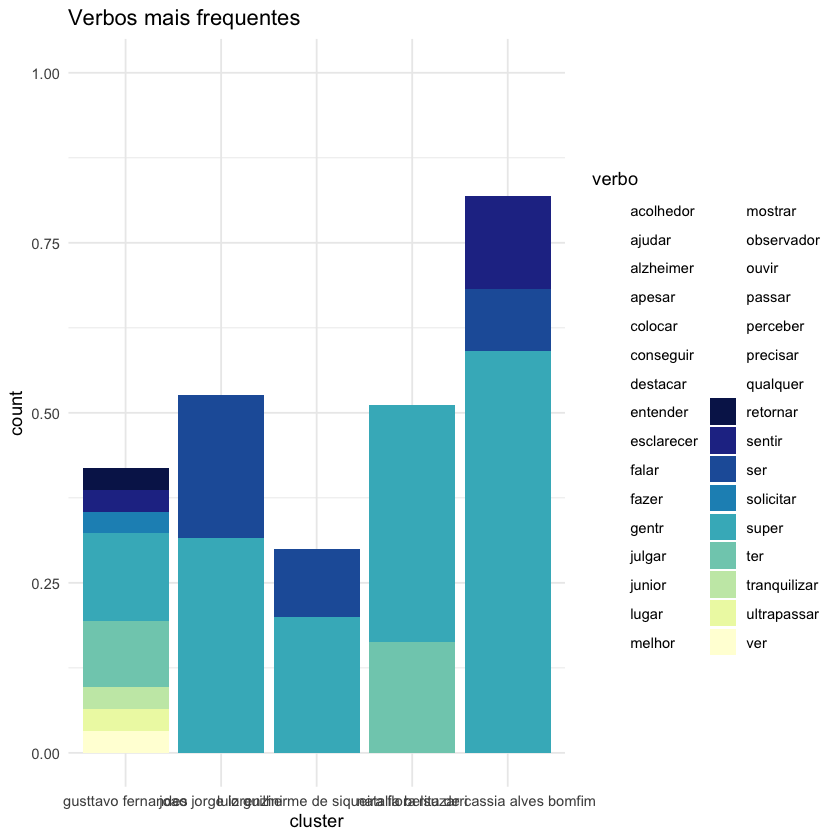

In [4]:
dra <- unique(CSS_txt$medico)

top_5_verbo <- function(grupo) {
  # Criar frq das palavras
  verbo <- textcnt(CSS_txt$comentario[CSS_txt$medico == grupo], method = "string",n = 1)
  verbo <- format(verbo)
  verbo$verbo <- row.names(verbo)
  verbo <- as_tibble(verbo)
  #Filtrar top 5 verbos
  verbo <- verbo %>%
    filter(str_detect(verbo, "r$")) %>%
    select(verbo, frq) %>%
    arrange(desc(frq)) %>%
    top_n(5)
  verbo$cluster = grupo
  verbo
}

lista <- purrr::map_dfr(dra, top_5_verbo)

# Grafico dos verbos
lista %>%
  ggplot() +
  aes(x = cluster, fill = verbo, weight = frq) +
  geom_bar(position = "fill") +
  scale_fill_brewer(palette = "YlGnBu", direction = -1) +
  #coord_flip() +
  theme_minimal() + labs(title = "Verbos mais frequentes")


Selecting by frq
Selecting by frq
Selecting by frq
Selecting by frq
Selecting by frq
Selecting by frq
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'conhecimento t��cnico' in 'mbcsToSbcs': dot substituted for <ef>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'conhecimento t��cnico' in 'mbcsToSbcs': dot substituted for <bf>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'conhecimento t��cnico' in 'mbcsToSbcs': dot substituted for <bd>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'conhecimento t��cnico' in 'mbcsToSbcs': dot substituted for <ef>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'conhecimento t��cnico' in 'mbcsToSbcs': dot substituted for <bf>”
Warning message in grid.Call(C_textBou

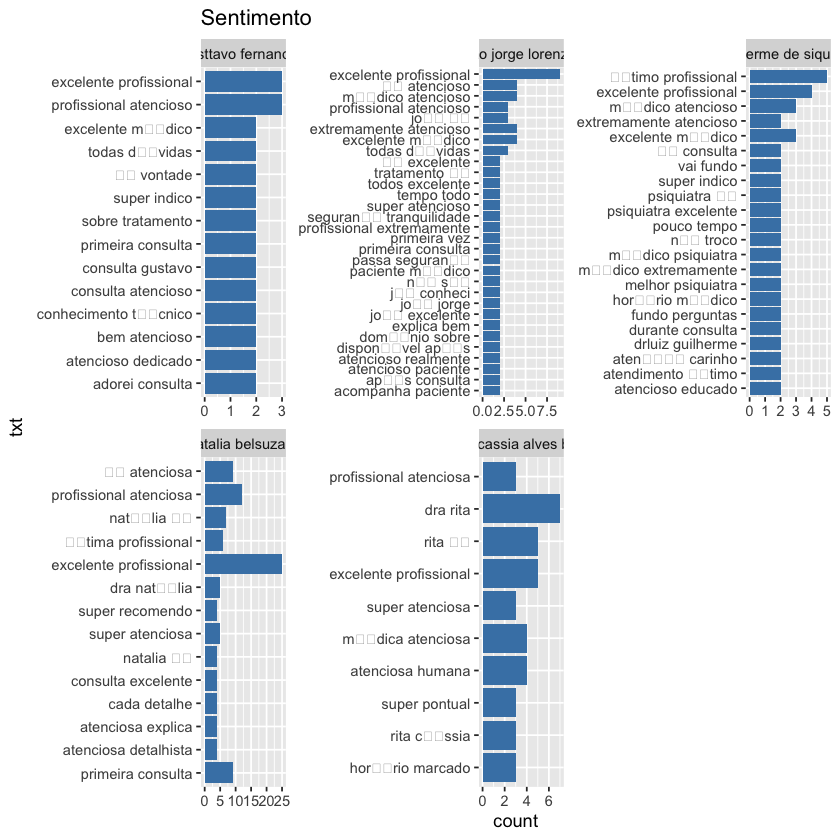

In [5]:
# Separar top 10 Conjugado
top_frase <- function(grupo) {
  # Criar frq das palavras
  txt <- textcnt(CSS_txt$comentario[CSS_txt$medico == grupo], method = "string",n = 2)
  txt <- format(txt)
  txt$txt <- row.names(txt)
  txt <- as_tibble(txt)
  #Filtrar top 5 verbos
  txt <- txt %>%
   # filter(str_detect(verbo, "r$")) %>%
    select(txt, frq) %>%
    arrange(desc(frq)) %>%
    top_n(10)
  txt$cluster = grupo
  txt
}

lista <- purrr::map_dfr(dra,top_frase)
lista <- lista %>%
 mutate(txt = fct_reorder(txt, frq))

ggplot(lista) +
 aes(x = txt, weight = frq) +
 geom_bar(fill = "#4682B4") +
 coord_flip() +
 theme_gray() +
 facet_wrap(vars(cluster), scales = "free") +
 labs(title = "Sentimento")

In [6]:
library(wordcloud2)

nuvem <- function(k){
  corpus = Corpus(VectorSource(enc2native(CSS_txt$comentario[CSS_txt$medico == k])))
  #preparando o df para wordcloud2
  tdm.word = TermDocumentMatrix(corpus) %>% as.matrix
  tdm.df = data.frame(words = rownames(tdm.word),
                      freq = apply(tdm.word,1,sum))
  a <- wordcloud2(tdm.df, size=.6)
  a
}

nuvem(dra[1])

HTML widgets cannot be represented in plain text (need html)